# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary in this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis.

In [269]:
import numpy as np
import pandas as pd
import xlsxwriter
import warnings
import matplotlib.pyplot as plt
import pandas_datareader as dr
import seaborn as sns

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# This python module was developed for this thesis
from TimeSeriesCrossValidation import splitTrain, splitTrainValTest

%matplotlib inline

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    previousStepsToShow: In-sample forecast
    stepsToForecast: Steps to forecast out-of-sample

In [270]:
previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
#xlab = 'Months/Year'; 
#ylab = 'Consumer Price Index';
#seasonal_periods = 12

stepsToForecast = [1, 5, 21];
df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
df = pd.DataFrame(df, columns= ['Date','Close'])
df.set_index('Date', drop=True, inplace=True)
df = df.truncate(after='2019-09-28')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'PSI20: Historical Closing Prices'
xlab = 'Business Days/Year'; 
ylab = 'Closing Price (Euro)';
seasonal_periods = 5

#stepsToForecast = [1, 5, 21];
#df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'SP500'
#xlab = 'Business Days/Year'; 
#ylab = 'Closing Price (Dollar)';
#seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

## Define Functions
    Defines helper functions

In [271]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true);
    ape = 100*(abs(y_pred - y_true) / y_true);
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' ' + xlab + ': MAE = ' + str(round(np.mean(ae[:i]), 2)) + ' (' + str(round(np.mean(ape[:i]), 2)) + '%)'  )

In [272]:
# Revert diffLogSeries values to real scale values using initialValue (Diff(Log(x)) -> x)
def revertLogDiff(initialValue, diffLogSeries):
    original = initialValue
    for i in np.arange(len(diffLogSeries)-1):
        original = np.append(original, original[-1]*(np.e**diffLogSeries[i]))
    return original

# Training Deep Neural Network

## Data Pre-Processing
    The options here include:
        - Slicing the data
        - Standardization or Normalization
        - Smoothing techniques
        - Stationarity techniques
        - Working with residuals

In [301]:
# Allows training data to be sliced
series_input = df_train.values[-2*12*21:]
saved_series_input = series_input

# Smoothing
#gamma = 0.3
#ExpMA = 0.0 
#for i in range(series_input.size):
#    ExpMA = gamma*series_input[i] + (1-gamma)*ExpMA
#    series_input[i] = ExpMA

# Select between 'Normalization', 'Standardization', 'DiffLog'
PreProcessing_str = 'DiffLog'

if (PreProcessing_str == 'Normalization'):
    scaler = MinMaxScaler()
    series_input = scaler.fit_transform(series_input)
elif (PreProcessing_str == 'Standardization'):
    scaler = StandardScaler()
    series_input = scaler.fit_transform(series_input)
elif (PreProcessing_str == 'DiffLog'):
    series_input = np.log(pd.DataFrame(series_input)).diff().dropna().values

## Model Selection (tune hyper-parameters)
    In this work, the models to be used will be:
        - Multilayer Perceptron (MLP)
        - Recurrent Neural Network (RNN)
        - Long Short-Term Memory (LSTM)
        
    Where the tunable hyper-parameters are:
        Explicit:
            - n_steps_input: Number of samples to be fed to the ANN
            - n_steps_jump: Number of samples to jump in training (speed up technique)
            - train_epochs: Number of epochs for the model to train
        Implicit:
            - Number of layers
            - Number of neurons of EACH layer
            - Activation function of EACH layer
            - Dropout
            - Optimization algorithm and loss function used in training
        
    Note: n_steps_forecast is chosen a-priori.

In [311]:
# Select between 'MLP', 'RNN', or 'LSTM'
NN_str = 'MLP'

n_steps_input = 84
n_steps_jump = 1

train_epochs = 100

model = Sequential()
if (NN_str == 'MLP'):
    model.add(Dense(100, activation='relu', input_dim=n_steps_input))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
elif (NN_str == 'RNN'):
    model.add(SimpleRNN(100, input_shape=(n_steps_input, 1), activation='relu', return_sequences=True))    
    model.add(SimpleRNN(10, activation='relu', return_sequences=False))
    model.add(Dense(stepsToForecast[-1]))
else:
    model.add(LSTM(100,input_shape=(n_steps_input, 1), dropout=0.2, activation='relu', return_sequences=True))  
    model.add(LSTM(30, activation='relu', dropout=0.1, return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dense(stepsToForecast[-1]))

model.compile(optimizer='adam', loss='mse')

## Cross-Validation
    The following cross-validation methos are implemented:
        - Forward Chaining
        - K-Fold
        - Group K-Fold
        
    Note: More info at https://github.com/DidierRLopes/TimeSeriesCrossValidation

In [160]:
# Select one of the following cross-validation methods
#.split_train_val_test_forwardChaining(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump) 
#.split_train_val_test_kFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
#.split_train_val_test_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

X_train, y_train, X_cv, y_cv, X_test, y_test = splitTrainValTest \
    .split_train_val_test_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

### Compute Cross-Validation Errors

In [33]:
dict_mae = {} 
for ix in np.arange(len(X_train)):
    
    print("%d/%d" % (ix+1, len(X_train)));
    
    if (NN_str == 'MLP'):
        X_train[ix] = np.squeeze(X_train[ix], axis=2)
        X_cv[ix] = np.squeeze(X_cv[ix], axis=2)
        X_test[ix] = np.squeeze(X_test[ix], axis=2)
    y_train[ix] = np.squeeze(y_train[ix], axis=2)
    y_cv[ix] = np.squeeze(y_cv[ix], axis=2)
    
    ## ------- TRAINING MODEL -------
    model.fit(X_train[ix], y_train[ix], epochs = train_epochs, verbose = 0);

    ## ------- TRAINING ERROR -------
    y_pred_train = model.predict(X_train[ix])
    y_pred_train_t = scaler.inverse_transform(y_pred_train)
    y_train_t = scaler.inverse_transform(y_train[ix]) 

    list_mae_train = list()
    for i in np.arange(len(y_train_t)):
        mae_train = mean_absolute_error(y_train_t[i,:], y_pred_train_t[i,:])
        list_mae_train.append(mae_train)
        
    ## ------- CROSS VALIDATION ERROR -------
    y_pred_cv = model.predict(X_cv[ix])
    y_pred_cv_t = scaler.inverse_transform(y_pred_cv)
    y_cv_t = scaler.inverse_transform(y_cv[ix]) 

    list_mae_cv = list()
    for i in np.arange(len(y_cv_t)):     
        mae_cv = mean_absolute_error(y_cv_t[i,: ], y_pred_cv_t[i,:])
        list_mae_cv.append(mae_cv)
        
    ## ------- TEST ERROR -------
    y_pred_test = model.predict(X_test[ix])
    y_pred_test_t = scaler.inverse_transform(y_pred_test)
    y_test_t = scaler.inverse_transform(y_test[ix]) 
    
    list_mae_test = list()
    for i in np.arange(len(y_test_t)):     
        mae_test = mean_absolute_error(y_test_t[i,: ], y_pred_test_t[i,:])
        list_mae_test.append(mae_test)
    
    dict_mae[str(ix)] = {'train': list_mae_train, 'cv': list_mae_cv, 'test': list_mae_test}
    
trainMae = np.mean([np.mean(dict_mae[str(runIx)]['train']) for runIx in np.arange(len(X_train))]);
cvMae = np.mean([np.mean(dict_mae[str(runIx)]['cv']) for runIx in np.arange(len(X_train))]);
testMae = np.mean([np.mean(dict_mae[str(runIx)]['test']) for runIx in np.arange(len(X_train))]);

1/5
2/5
3/5
4/5
5/5


### Cross-Validation Performance

In [50]:
## Assess Training / Cross-Validation / Test
# DEBUG_LEVEL = 0 - Only shows STATS of ALL runs
#               1 - Shows the average MAE through runs 
#               2 - Shows the MAE at each run at each train/cv/test set    

DEBUG_LEVEL = 0

print("STATS of ALL runs")    
print("Train avg MAE avg = %.4f" % trainMae) 
print("Cross-Validation avg MAE avg = %.4f" % cvMae)
print("Test avg MAE avg = %.4f" % testMae)

list_train_mae = list()
list_cv_mae = list()
list_test_mae = list()
for runIx in np.arange(len(X_train)):
    if (DEBUG_LEVEL > 0):
        print("")
        print("----- RUN NUMBER %d -----" % (runIx+1))

    list_train_mae.append(np.mean(dict_mae[str(runIx)]['train']))
    if (DEBUG_LEVEL > 0):
        print ("Train MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['train'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['train'])>1):
                print("Individual trains: " + str([round(x,4) for x in dict_mae[str(runIx)]['train']]))
    
    list_cv_mae.append(np.mean(dict_mae[str(runIx)]['cv']))
    if (DEBUG_LEVEL > 0):
        print ("Cross-Validation MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['cv'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['cv'])>1):
                print("Individual cross-validations: " + str([round(x,4) for x in dict_mae[str(runIx)]['cv']]))
            
    list_test_mae.append(np.mean(dict_mae[str(runIx)]['test']))
    if (DEBUG_LEVEL > 0):
        print ("Test MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['test'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['test'])>1):
                print("Individual tests: " + str([round(x,4) for x in dict_mae[str(runIx)]['test']]))

STATS of ALL runs
Train avg MAE avg = 39.4762
Cross-Validation avg MAE avg = 212.6701
Test avg MAE avg = 259.2878


### Cross-Validation Plot

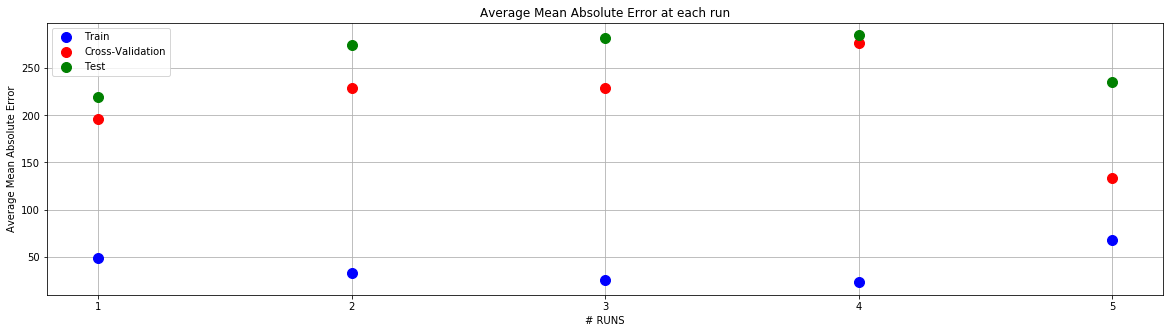

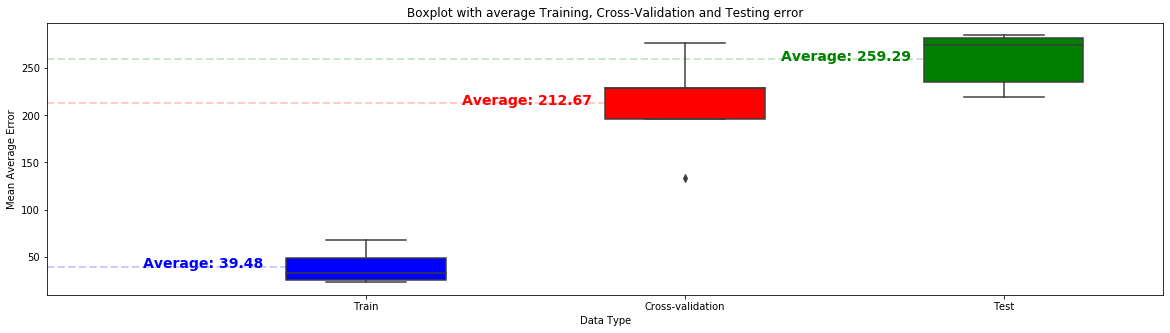

In [55]:
# Plot Mean Absolute Errors of each run
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(X_train))+1, list_train_mae, 'bo', markersize=10, label = 'Train')
plt.plot(np.arange(len(X_train))+1, list_cv_mae, 'ro', markersize=10, label = 'Cross-Validation')
plt.plot(np.arange(len(X_train))+1, list_test_mae, 'go', markersize=10, label = 'Test')
plt.legend()
plt.xlabel('# RUNS')
plt.ylabel('Average Mean Absolute Error')
plt.title('Average Mean Absolute Error at each run')
plt.xticks(np.arange(len(X_train))+1)
plt.grid()

# Plot Mean Absolute Errors of each run
x_bp = np.concatenate((np.repeat('Train', len(list_train_mae)), \
                       np.repeat('Cross-validation', len(list_cv_mae)), 
                       np.repeat('Test', len(list_test_mae))), axis = 0)

y_bp = np.concatenate((list_train_mae, \
                       list_cv_mae, \
                       list_test_mae), axis = 0)

df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
bplot.artists[2].set_facecolor('green')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.2)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.2)
plt.plot([-1,2], [testMae, testMae],'g--', lw=2, alpha=0.2)
plt.xlim([-1, 2.5])
plt.text(-0.70, trainMae-1.3, 'Average: ' + str(round(trainMae,2)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, cvMae-1.3, 'Average: ' + str(round(cvMae,2)), fontsize=14, color='r', fontweight='bold')
plt.text(1.30, testMae-1.3, 'Average: ' + str(round(testMae,2)), fontsize=14, color='g', fontweight='bold')
plt.show()

## Model prediction
    This uses the entire samples to train

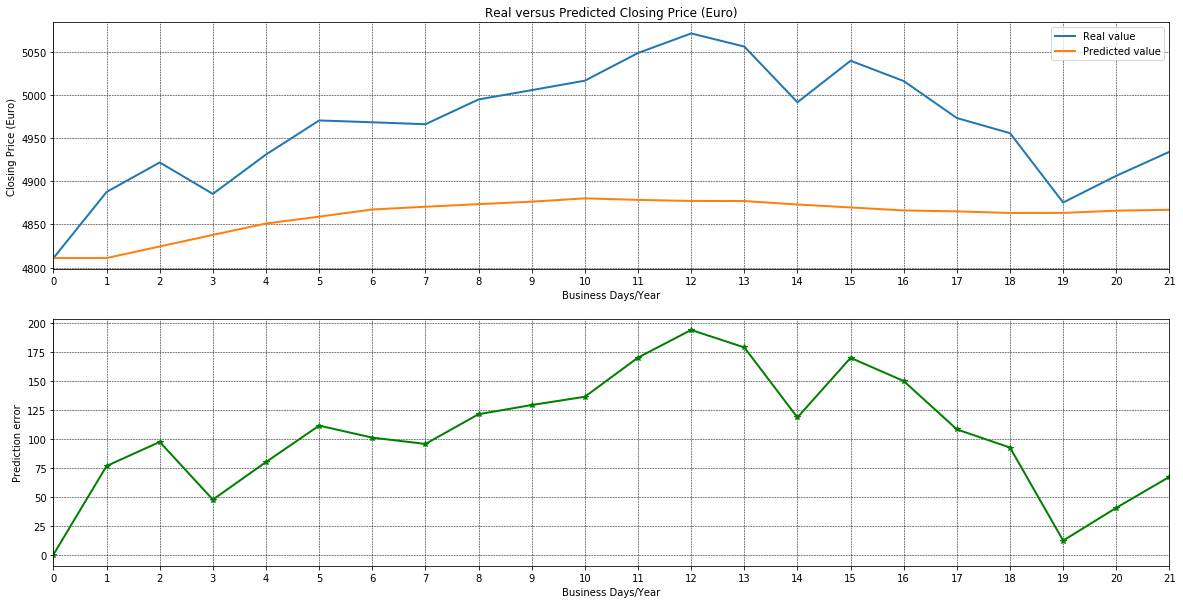

Prediction for 1 Business Days/Year: MAE = 76.66 (1.57%)
Prediction for 5 Business Days/Year: MAE = 82.68 (1.68%)
Prediction for 21 Business Days/Year: MAE = 109.59 (2.19%)


In [312]:
X_test, y_test = splitTrain.split_train(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
if (NN_str == 'MLP'):
    X_test = np.squeeze(X_test, axis=2)
y_test = np.squeeze(y_test, axis=2)

## ------- TRAIN MODEL WITH ALL DATA-------
model.fit(X_test, y_test, epochs = train_epochs, verbose = 0);

if (NN_str == 'MLP'):
    yhat = model.predict(series_input[-n_steps_input:].T, verbose=0)
else:
    yhat = model.predict(series_input[-n_steps_input:].reshape(1, n_steps_input, 1), verbose=0)
    
y_pred_test = yhat.tolist()

if PreProcessing_str in ['Normalization', 'Standardization']: 
    y_pred_test = scaler.inverse_transform(y_pred_test)
elif PreProcessing_str == 'DiffLog':
    y_pred_test = revertLogDiff(saved_series_input[-1], y_pred_test[0])

predictions_array = np.array(y_pred_test).flatten()
    
real_array = np.array(df_test.values).flatten()

# plot results
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab) 
plt.plot(range(0,len(real_array)+1), np.concatenate((saved_series_input[-1], real_array), axis=0), linewidth=2)
plt.plot(range(0,len(predictions_array)+1), np.concatenate((saved_series_input[-1], predictions_array), axis=0), linewidth=2)
plt.xlim([0,len(predictions_array)])
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.plot(range(0,len(real_array-predictions_array)+1), np.concatenate((np.array([0]), real_array-predictions_array), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.xlim([0,len(predictions_array)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

printMAEpred(real_array, predictions_array, stepsToForecast)